In [1]:
%matplotlib nbagg

import load
import pickle
import util
import matplotlib.pyplot as plt
import numpy as np
import collections as col
import random
from sklearn.cross_validation import train_test_split
import math


In [2]:
#review = load.shuffle_data()
#pickle.dump(review,open("processed_text.p","wb"))
X = pickle.load(open("processed_text.p", "rb" ))

In [3]:
train,test = train_test_split(X,test_size=0.25, random_state=42)


### Q 5 Sparse Representation of Data

In [4]:
def bow_of_example(example):
    c = col.Counter()
    for elem in range(len(example) -1):
        c[example[elem]] = c[example[elem]] + 1
    return c


In [5]:
def getX(dataset):
    k = []
    for example in dataset:
        k.append(bow_of_example(example))
    return k

In [7]:
def getY(dataset):
    y = []
    for example in dataset:
        y.append(example[len(example)-1])
    return y


### TF-IDF calcualation

In [37]:
def performTfIdf(list_of_bows):
    for item in list_of_bows:
        for m,n in item.items():
            item[m] = n*(-1)*(np.log((doc_freq[m])/len(list_of_bows)))
    return list_of_bows

## Q6 Pegasos Algorithm

In [10]:
def pegasos_1(lamda,X_shuf,y_shuf,max_epochs):
    epoch = 0
    t = 0
    w = col.Counter()
    while epoch <= max_epochs:
        data = list(zip(X_shuf,y_shuf))
        random.shuffle(data)
        X_shuf,y_shuf = zip(*data) 
        j = 0
        for x in X_shuf:
            t = t+1
            eta_t = 1/(lamda*t)
            if (y_shuf[j]*util.dotProduct(w,x) < 1):
                util.increment(w,-(eta_t*lamda), w)
                util.increment(w,eta_t*y_shuf[j],x)
            else:
                util.increment(w,-(eta_t*lamda), w)
            j = j + 1
        epoch = epoch + 1
    return w

In [11]:
X_train = getX(train)
y_train = getY(train)
X_test = getX(test)
y_test = getY(test)

In [12]:
def pegasos_fast(lamda, X_shuf,y_shuf,max_epochs):
    epoch = 0
    t = 1
    s = 1
    W_rep = col.Counter()
    w = col.Counter()
    util.increment(w,s,W_rep)
    while epoch <= max_epochs:
        data = list(zip(X_shuf,y_shuf))
        random.shuffle(data)
        X_shuf,y_shuf = zip(*data)
        for j in range(len(X_shuf)):
            t = t+1
            eta_t = 1/(lamda*t)
            if (y_shuf[j]*util.dotProduct(w,X_shuf[j]) < 1):
                s = (1 - (eta_t*lamda))*s
                if (s == 0):
                    s = 1
                    W_rep = col.Counter()
                    w.clear()
                    continue
                util.increment(W_rep,(1/s)*(eta_t*y_shuf[j]),X_shuf[j])
                w.clear()
                util.increment(w,s,W_rep)
        epoch = epoch + 1
        
    return w

In [ ]:
#%lprun -f pegasos_fast pegasos_fast(0.01, w, k, y, 3)
w = pegasos_fast(0.01,X_train,y_train,3)
pickle.dump(w,open("weight_fast.p","wb"))

In [ ]:

#%load_ext line_profiler
#%lprun -f pegasos_1 pegasos_1(0.01, w, k, y, 3)
w = pegasos(0.01,X_train,y_train,3)
pickle.dump(w,open("weight_slow.p","wb"))

## Q6.4 Report on time taken to run Pegasos on both fast and slow approaches

#### Time taken for Pegasos slow approach for 4 epochs
Timer unit: 1e-06 s

Total time: 427.972 s
File: <ipython-input-10-eab02341035c>
Function: pegasos_1 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def pegasos_1(lamda, w, X_shuf,y_shuf,max_epochs):
     2         1            3      3.0      0.0      epoch = 0
     3         1            1      1.0      0.0      t = 0
     4         1           15     15.0      0.0      w_old = col.Counter()
     5         5            4      0.8      0.0      while epoch <= max_epochs:
     6                                                   #data = list(zip(k,y))
     7                                                   #random.shuffle(data)
     8                                                   #X_shuf,y_shuf = zip(*data) 
     9         4            2      0.5      0.0          j = 0
    10      6004         7292      1.2      0.0          for x in X_shuf:
    11      6000         4641      0.8      0.0              t = t+1
    12      6000        19638      3.3      0.0              eta_t = 1/(lamda*t)
    13      6000      2260223    376.7      0.5              if (y_shuf[j]*util.dotProduct(w,x) < 1):
    14      1654    108467893  65579.1     25.3                  util.increment(w,-(eta_t*lamda), w)
    15      1654       718471    434.4      0.2                  util.increment(w,eta_t*y_shuf[j],x)
    16                                                       else:
    17      4346    316472907  72819.4     73.9                  util.increment(w,-(eta_t*lamda), w)
    18      6000        21204      3.5      0.0              j = j + 1
    19         4            2      0.5      0.0          epoch = epoch + 1
    20         1            1      1.0      0.0      return w

#### Time taken for Pegasos_fast Algorithm for 4 epochs

Timer unit: 1e-06 s

Total time: 89.9295 s
File: <ipython-input-19-d5fbd87c0efa>
Function: pegasos_fast at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def pegasos_fast(lamda, w, X_shuf,y_shuf,max_epochs):
     2         1            3      3.0      0.0      epoch = 0
     3         1            1      1.0      0.0      t = 1
     4         1            0      0.0      0.0      s = 1
     5         1           15     15.0      0.0      W_rep = col.Counter()
     6         1            5      5.0      0.0      w = col.Counter()
     7         1            7      7.0      0.0      util.increment(w,s,W_rep)
     8                                               #w = s * W_rep.values()
     9         5            6      1.2      0.0      while epoch <= max_epochs:
    10      6004        11697      1.9      0.0          for j in range(len(X_shuf)):
    11      6000         4987      0.8      0.0              t = t+1
    12      6000         9962      1.7      0.0              eta_t = 1/(lamda*t)
    13      6000      1910109    318.4      2.1              if (y_shuf[j]*util.dotProduct(w,X_shuf[j]) < 1):
    14      1354         3008      2.2      0.0                  s = (1 - (eta_t*lamda))*s
    15      1354         1235      0.9      0.0                  if (s == 0):
    16                                                               s = 1
    17                                                               W_rep = col.Counter()
    18                                                               w.clear()
    19                                                               continue
    20      1354       546728    403.8      0.6                  util.increment(W_rep,(1/s)*(eta_t*y_shuf[j]),X_shuf[j])
    21      1354      2109498   1558.0      2.3                  w.clear()
    22      1354     85332236  63022.3     94.9                  util.increment(w,s,W_rep)
    23         4            3      0.8      0.0          epoch = epoch + 1
    24                                                   
    25         1            0      0.0      0.0      return

### Observation

Time taken by Faster approach is approximately 5 times more efficient than the slower approach, as seen from above report.


## Q6.5 zero - one loss

In [ ]:
# get the x values from test set - X
# get the y values from test set - y
# get the weight vector generated by pegasos - W
# compute the yxW. if this is greater than 0 --> pass else fail
# Compute the precent error = fail/total * 100
y_fail = []
X_fail = []

In [13]:
from __future__ import division
def zero_one_loss(w,X,y):
    result = col.Counter()
    j = 0
    for x in X_test:
        if ((y_test[j]*util.dotProduct(w,x)) > 0):
            result['correct'] = result['correct'] + 1
        else:
            result['incorrect'] = result['incorrect'] + 1
            y_fail.append(y_test[j])
            X_fail.append(x)
            
        j = j+1

    #print result['correct']
    #print result['incorrect']
    standard_error = math.sqrt((result['correct'] * result['incorrect'])/(result['correct'] + result['incorrect']))
    percent_error = result['incorrect']/(result['correct'] + result['incorrect'])
    return percent_error, standard_error      


In [58]:
theta = pickle.load(open("weight_fast.p","rb"))
percent_error, standard_error = zero_one_loss(theta,X_test,y_test)
print "percentage error is : ", percent_error_basic * 100
print "standard error is : " , standard_error_basic

percentage error is :  20.8
standard error is :  9.07568179257


## Q6.6 Regularization parameter

<IPython.core.display.Javascript object>


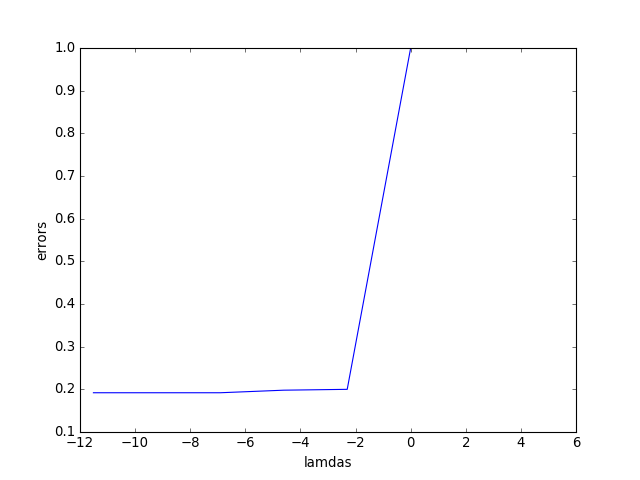

In [61]:
start = -5
stop = 3
errors = []
lamdas = []
for i in range(start,stop):
    lamda = 10 ** i
    w = pegasos_fast(lamda,X_train,y_train,2)
    errors.append(zero_one_loss(w,X_test,y_test)[0])
    lamdas.append(lamda)
    
plt.xlabel("lamdas")
plt.ylabel("errors")
plt.plot(np.log(lamdas),errors)
plt.show()

    



### Observation - 

Optimized lambda value was observed at 0.01. The loss increases when lambda value increases beyond 1.

## Q7 Error Analysis

In [59]:
from prettytable import PrettyTable
from operator import itemgetter
print 'actual label is ' , y_fail[0], 'but this is predicted to be a' , y_fail[0] * -1
complete_list = []

for m,n in X_fail[0].items():
    list = []
    list.append(abs(w[m] * n))
    list.append(w[m])
    list.append(n)
    list.append(w[m]*n)
    list.append(m)

    
    complete_list.append(list)

sorted_list = sorted(complete_list, key=itemgetter(0), reverse = True)

t = PrettyTable(['feature', 'abs(w_i*x_i)', 'w_i', 'x_i', 'w_i*x_i'])
for l in sorted_list:
    t.add_row([l[4],l[0],l[1],l[2],l[3]])
print t


actual label is  -1 but this is predicted to be a 1
+----------------------+------------------+-------------------+-----+-------------------+
|       feature        |   abs(w_i*x_i)   |        w_i        | x_i |      w_i*x_i      |
+----------------------+------------------+-------------------+-----+-------------------+
|          a           |  81.5021194844   |   3.88105330878   |  21 |   81.5021194844   |
|         and          |   68.658571382   |   4.03873949306   |  17 |    68.658571382   |
|         bad          |  62.2144555069   |   -20.7381518356  |  3  |   -62.2144555069  |
|          as          |  53.8246986698   |   5.38246986698   |  10 |   53.8246986698   |
|         are          |  48.3434550772   |   6.90620786817   |  7  |   48.3434550772   |
|          is          |  33.0035957604   |   2.20023971736   |  15 |   33.0035957604   |
|        every         |  29.6255052837   |   -7.40637632094  |  4  |   -29.6255052837  |
|       director       |  28.1603321383   |   -9

In [60]:
print 'actual label is ' , y_fail[3], 'but this is predicted to be a' , y_fail[3] * -1
complete_list = []

for m,n in X_fail[3].items():
    list = []
    list.append(abs(w[m] * n))
    list.append(w[m])
    list.append(n)
    list.append(w[m]*n)
    list.append(m)

    
    complete_list.append(list)

sorted_list = sorted(complete_list, key=itemgetter(0), reverse = True)

t = PrettyTable(['feature', 'abs(w_i*x_i)', 'w_i', 'x_i', 'w_i*x_i'])
for l in sorted_list:
    t.add_row([l[4],l[0],l[1],l[2],l[3]])
print t

actual label is  -1 but this is predicted to be a 1
+-----------------------------------------+------------------+-------------------+-----+-------------------+
|                 feature                 |   abs(w_i*x_i)   |        w_i        | x_i |      w_i*x_i      |
+-----------------------------------------+------------------+-------------------+-----+-------------------+
|                   many                  |  48.1657116573   |   12.0414279143   |  4  |   48.1657116573   |
|                   and                   |  44.4261344236   |   4.03873949306   |  11 |   44.4261344236   |
|                   very                  |  38.9926579747   |   12.9975526582   |  3  |   38.9926579747   |
|                    so                   |  36.9150046888   |   -9.2287511722   |  4  |   -36.9150046888  |
|                  action                 |  34.0585325655   |   -11.3528441885  |  3  |   -34.0585325655  |
|                   but                   |  33.6910616342   |   -5.61517693

#### Error analysis Report

Both the examples above show that some stop words like "and", "a", "are" etc. have received the highest score leading to wrong predictions. Therefore, one way to fix this issue is to remove the stop words from the data in the pre-processing stage so that weights are distributed effectively. 

Some new features that can help improve the predictions will be - 

1. A category which specifies which parts of speech a word belongs to. For example - If a word is an adjective, it should not be penalized as adjectives best describe the opinion of the reviewer. However, conjuctions and articles that are used extensively in the document should be penalized as they do not add any value to the opinion.

2. An engineered feature which says whether a word belongs to one of these categories - positive, partially positive, negative, partially negative and neutral.

3. Some words can be clubbed with the preceding or succeeding word to make a more meaningful feature. After performing this, we can classify these features to one of the categories in Point 2

## Q.8 Comparison of Performance based on feature sets 


The following approaches were tried to check the performance of the model -

1. Excluding stop words from being included in the model. This prevented in the distribution of weights to meaningful words.
2. Implementing TF-IDF methodology on the data to check if the performance increases. This penalizes the words which appear across all the documents

Both the approaches resulted in a higher percentage error and standard error than the basic approach that we followed in the Question 6. The results can be seen below under appropriate sections

In [14]:
doc_freq = col.Counter()
stopwords = col.Counter()
stopwords = pickle.load(open("stop.p","rb"))


In [29]:
def bow_of_example_Q8(example,criteria):
    c = col.Counter()
    for elem in range(len(example) -1):
        if (criteria == "stopwords_only") or (criteria == "both"):
            if (stopwords[example[elem]] == 1):
                continue
        if ((criteria == "tfidf_only") or (criteria == "both")):
            if (c[example[elem]] == 0):
                doc_freq[example[elem]] = doc_freq[example[elem]] + 1
        c[example[elem]] = c[example[elem]] + 1
    return c

In [31]:
def getX_Q8(dataset,criteria):
    k_Q8 = []
    for example in dataset:
        k_Q8.append(bow_of_example_Q8(example,criteria))
    if((criteria == "tfidf_only") or (criteria == "both")):
        k_tfidf = performTfIdf(k_Q8)
        return k_tfidf
    else:
        return k_Q8

### Only Stopwords Performance

In [23]:
X_train_Q8 = getX_Q8(train,"stopwords_only")
X_test_Q8 = getX_Q8(test, "stopwords_only")

In [24]:
theta_sw_only = pegasos_fast(0.01,X_train_Q8,y_train,1)

In [27]:
percent_error,standard_error = zero_one_loss(theta_sw_only,X_test_Q8,y_test)
print "percentage error is : ", percent_error * 100
print "standard error is : " , standard_error

percentage error is :  21.6
standard error is :  9.20173896609


### Only Tfidf Performance 

In [44]:
X_train_Q8 = getX_Q8(train,"tfidf_only")
X_test_Q8 = getX_Q8(test,"tfidf_only")

In [45]:
theta_tfidf = pegasos_fast(0.01,X_train_Q8,y_train,1)

In [46]:
percent_error_tfidf,standard_error_tfidf = zero_one_loss(theta_tfidf,X_test_Q8,y_test)
print "percentage error is : ", percent_error_tfidf * 100
print "standard error is : " , standard_error_tfidf

percentage error is :  61.8
standard error is :  10.8645294422


### Both Stopwords and TF-Idf

In [47]:
X_train_Q8 = getX_Q8(train,"both")
X_test_Q8 = getX_Q8(test, "both")

In [48]:
theta_both = pegasos_fast(0.01,X_train_Q8,y_train,1)

In [49]:
percent_error_both, standard_error_both = zero_one_loss(theta_both,X_test_Q8,y_test)
print "percentage error is : ", percent_error_both * 100
print "standard error is : " , standard_error_both

percentage error is :  54.4
standard error is :  11.1369654754


### Performance on basic Feature Set without adding new features

In [55]:
theta_basic = pegasos_fast(0.01,X_train,y_train,1) ## This is over the data used previously in questions 1-7

In [56]:
percent_error_basic, standard_error_basic = zero_one_loss(theta_basic,X_test,y_test)
print "percentage error is : ", percent_error_basic * 100
print "standard error is : " , standard_error_basic

percentage error is :  20.8
standard error is :  9.07568179257
